In [765]:
import load

df = load.data("steal_attempt", season=13, roles = ("batter", "pitcher", "fielder", "relevant_runner"))


df = df[df['event_type']=="StealAttempt2"]

df["laser_scaled"] = load.player_attribute(df, 'relevant_runner', 'laserlikeness', vibes=True, mods=True, items=True, broken_items=True)
df["thirst_scaled"] = load.player_attribute(df, 'relevant_runner', 'baseThirst', vibes=True, mods=True, items=True, broken_items=True)

df["laser"] = load.player_attribute(df, 'relevant_runner', 'laserlikeness', vibes=False, mods=False, items=True, broken_items=True)
df["thirst"] = load.player_attribute(df, 'relevant_runner', 'baseThirst', vibes=False, mods=False, items=True, broken_items=True)

df["pwatch_scaled"] = load.player_attribute(df, 'pitcher', 'watchfulness', vibes=False, mods=False, items=True, broken_items=True)

df["fwatch_scaled"] = load.player_attribute(df, 'fielder', 'watchfulness', vibes=True, mods=True, items=True, broken_items=True)

df["elongation"] = load.stadium_attribute(df, 'elongation', center=False)
df["inconvenience"] = load.stadium_attribute(df, 'inconvenience', center=False)

In [766]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [767]:
df = df[(df["pitching_team_hype"] == 0) & (df["batting_team_hype"] == 0)]
dfc = df.copy()
for exclude_mod in ["EARLY_TO_PARTY", "LATE_TO_PARTY"]:
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in ["EARLY_TO_PARTY", "LATE_TO_PARTY", "OVERPERFORMING", ]:
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in ["UNDEFINED"]:
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in ["UNDEFINED"]:
    dfc = dfc[~dfc["relevant_runner_mods"].astype(str).str.contains(exclude_mod)]
dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

len(dfc)

20584

In [768]:
dfc["laser2"] = (dfc["laser"])**2
dfc["lasersq_thirst"] = (dfc["laser2"] * (1 + 0.2 * dfc["relevant_runner_vibes"]) * dfc["thirst_scaled"])**3

dfc["watch"]  = (3*dfc["pwatch_scaled"] + dfc["fwatch_scaled"])

dfc["bhype"] = dfc["batting_team_hype"]
dfc["phype"] = dfc["pitching_team_hype"] 

dfc["hypediff"] = (dfc["phype"] - dfc["bhype"])


In [799]:
X = dfc[
    [
        "roll",
        "passed",
        #"thirst_scaled",
        #"laser_scaled",
        "fwatch_scaled",
        "pwatch_scaled",
        #"watch",
        "lasersq_thirst",
        #"laser2",
        "elongation",
        "inconvenience",
        #"laser3"

    ]
].copy()
X = X[X["roll"] > 0.001]
#X = X[~X["lasersq_thirst"].isna()]
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = 0.09
pins = [ (0.0013, "lasersq_thirst"),
        (-0.02, "fwatch_scaled"),
        (-0.06, "pwatch_scaled"),
        (-0.06, "elongation"),
        (-0.0385, "inconvenience")

]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-15, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_   #- np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[20469     0]
 [    0    92]]
0 outliers
1.0
0.09


[(1.0, 'roll')]

In [ ]:
#Works for Season 12, Home Steals
#dfc["threshold"] = 0.04 + 0.0016*dfc["lasersq_thirst"] - 0.02*dfc["fwatch_scaled"] - 0.06*dfc["pwatch_scaled"]

#Works for Season 14, Home Steals
#dfc["threshold"] = 0.09 + 0.0013*dfc["lasersq_thirst"] - 0.02*dfc["fwatch_scaled"] - 0.06*dfc["pwatch_scaled"] - 0.06*dfc["elongation"] - 0.0385*dfc["inconvenience"]



KeyError: 'threshold'

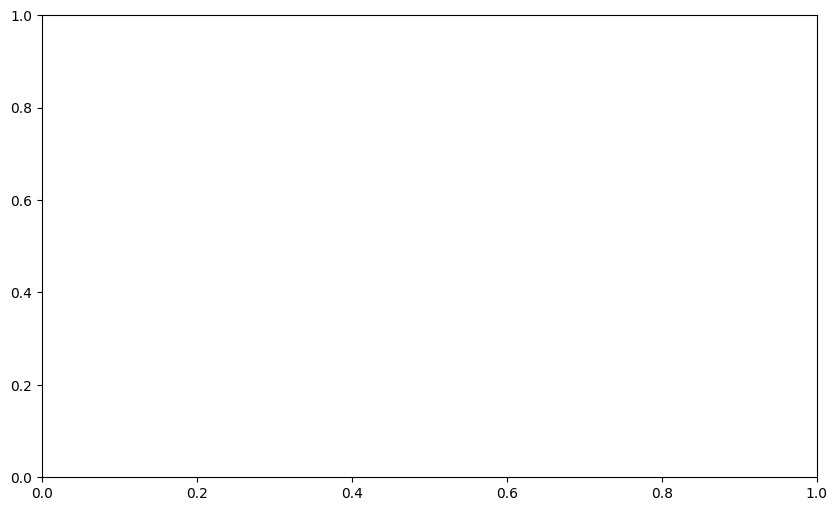

In [771]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="NoAttempt", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Attempt", marker=CARETLEFTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Steal Attempts")
ax.set_xlim([-0.1, 1])
ax.set_ylim([0.0, 1])
ax.legend()

,offset,event_type,roll,threshold,relevant_runner_name,fielder_mods,relevant_runner_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
9737,-0.001808,StealAttempt2,0.007820,0.009629,Engine Eberhardt,SMOOTH,,POPCORN_PAYOUTS,BASE_INSTINCTS,10,b63333a3-f830-4bff-a9ee-8193b85cf18c,320
79978,0.000098,StealAttempt2,0.016492,0.016394,Eizabeth Guerra,,,,PARTY_TIME;BIRD_SEED,93,7fac7adb-e35a-42ae-b84f-04641e2993e4,225


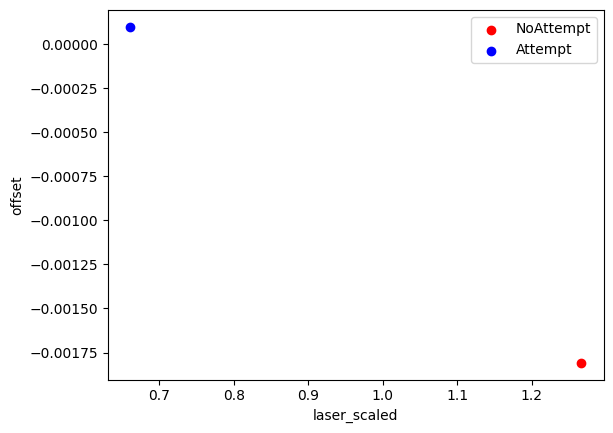

In [ ]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
outliers = outliers[outliers["roll"] > 0.001]


fig, ax = plt.subplots(1)
x_val = "laser_scaled"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="NoAttempt")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Attempt")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "event_type",
       "roll", "threshold", 
       "relevant_runner_name", "fielder_mods", "relevant_runner_mods", "batting_team_mods", "pitching_team_mods",
       "day",  "game_id", "play_count"]].sort_values('offset')


In [ ]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.1263447431826405
0.0010041574522214
